<a href="https://colab.research.google.com/github/OkiHeo/python_machine_learning/blob/master/ch9_%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST의 딥러닝

In [3]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

#------------------------------------------------------------------

from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Instructions for updating:
non-resource variables are not supported in the long term


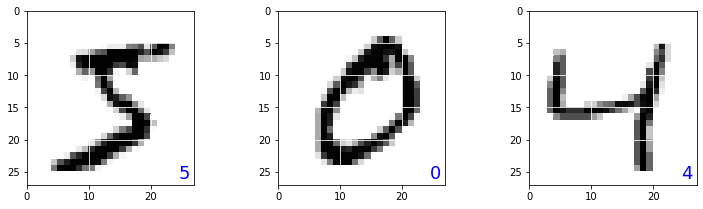

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1, figsize=(12, 3.2))
plt.subplots_adjust(wspace=0.5)
plt.gray()

for id in range(3):
  plt.subplot(1, 3, id+1)
  img = x_train[id, :, :]     # id번째 이미지 (28x28)를 img에 저장
  plt.pcolor(255-img)
  plt.text(24.5, 26, "%d" %y_train[id], color='blue', fontsize=18)
  plt.xlim(0, 27)
  plt.ylim(27, 0)
  plt.grid('on', color='white')
plt.show()

y_train[id] 에는 x_train[id, :, :]에 해당하는 숫자가 저장되어있다.

## 2층 피드 포워드 네트워크 모델

In [0]:
from keras.utils import np_utils


x_train = x_train.reshape(60000, 784)     # 60000x(28x28) -> 60000x784로 변환. 3차원배열을 2차원배열로 reshape
x_train = x_train.astype('float32')       # 저장된 값의 자료형을 float32형으로 변환
x_train = x_train/255                     # 0~1사이의 실수 값으로 변환한다.

num_classes = 10                          # 0~9를 표시하는 이미지라는 클래스가 존재한다.

y_train = np_utils.to_categorical(y_train, num_classes)     # y_train의 요소를 1-of-K 부호화법으로 변경한다.